In [74]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import sys
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert, classes
import numpy as np
import imp
import pandas as pd
import seaborn as sns
from sklearn_crfsuite import CRF
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from operator import itemgetter
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# import sklearn.grid_search

In [8]:
dir_name='duplicate'
final_pred_name='merged.crf.bert.ens.c.w.l'
final_feature_name='local.plot.tfidf.30'
dataset_name='dataset_tf.word.char.lemma.full_splits'
cv_split_name='cv_splits_per_client'
seq_len=15
step=15
file_prefix='threshold'

In [9]:
all_pred_crf01=common_utils.load_db(dir_name,final_pred_name)

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/merged.crf.bert.ens.c.w.l.csv,  index False


In [10]:
cv_splits_loaded=common_utils.load_json(dir_name,cv_split_name)

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/cv_splits_per_client.json


In [11]:
all_pred_crf01

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,sent_idx,crf_group,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true,ens_par
0,1,0,1,0,0.45525,0.54475,0,0,0,1,...,0.930,0.070,0,0,0.84699,0.15301,1,0,0,0
1,1,0,0,0,0.76593,0.23407,1,1,1,1,...,0.943,0.057,1,0,0.84595,0.15405,1,0,0,1
2,1,0,0,0,0.79398,0.20602,2,2,2,1,...,0.972,0.028,2,0,0.84583,0.15417,1,0,0,2
3,1,0,0,0,0.59757,0.40243,3,3,3,1,...,0.957,0.043,3,0,0.84611,0.15389,1,0,0,3
4,1,0,1,0,0.40709,0.59291,4,4,4,1,...,0.968,0.032,4,0,0.84717,0.15283,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38429,79,7,0,0,0.70014,0.29986,2983,171,254,79,...,0.872,0.128,2983,0,0.84198,0.15802,79,7,0,171
38430,79,7,0,0,0.84534,0.15466,2984,172,255,79,...,0.994,0.006,2984,0,0.84326,0.15674,79,7,0,172
38431,79,7,0,0,0.85442,0.14558,2985,172,256,79,...,0.999,0.001,2985,0,0.84387,0.15613,79,7,0,172
38432,79,7,0,0,0.84201,0.15799,2986,172,257,79,...,1.000,0.000,2986,0,0.84348,0.15652,79,7,0,172


In [15]:
feature_cols=['bert_proba_0','bert_proba_1','crf_proba_1','crf_proba_1']

In [16]:
X=(all_pred_crf01[feature_cols]).to_numpy()
y=(all_pred_crf01['bert_true']).to_numpy()
groups=(all_pred_crf01['bert_group']).to_numpy()

In [17]:
X

array([[0.45525, 0.54475, 0.07   , 0.07   ],
       [0.76593, 0.23407, 0.057  , 0.057  ],
       [0.79398, 0.20602, 0.028  , 0.028  ],
       ...,
       [0.85442, 0.14558, 0.001  , 0.001  ],
       [0.84201, 0.15799, 0.     , 0.     ],
       [0.86306, 0.13694, 0.001  , 0.001  ]])

In [18]:
groups.shape,y.shape,X.shape

((38434,), (38434,), (38434, 4))

### Hold one split for testing

In [19]:
splits_hold_one=common_utils.load_json(dir_name,'splits_hold_one')

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/splits_hold_one.json


In [135]:
splits_hold_one

{'0': {'test': [1, 2, 3, 10, 11, 12, 13, 14, 15, 16],
  'train': [4,
   5,
   6,
   7,
   8,
   9,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80]},
 '1': {'test': [8, 20, 22, 23, 25, 27, 32, 73, 74, 75],
  'train': [4,
   5,
   6,
   7,
   9,
   17,
   18,
   19,
   21,
   24,
   26,
   28,
   29,
   30,
   31,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   72,
   76,
   77,
   78,

In [20]:
my_test_split=classes.MyEnsFold(splits_hold_one)

In [21]:
train_splits={}
test_splits={}

for k,v in splits_hold_one.items():
    if k=='0':
        test_splits[k]=v
    else:
        train_splits[k]=v

In [22]:
def my_score_func(y, y_pred, **kwargs):
    recall=recall_score(y, y_pred, average='binary')*kwargs['recall_weight']
    f1=f1_score(y,y_pred,average=kwargs['f1_type'])*(1-kwargs['recall_weight'])
    return recall+f1

In [23]:
imp.reload(classes)
train_splitter=classes.MyEnsFold(train_splits)
test_splitter=classes.MyEnsFold(test_splits)

In [190]:
my_scorer=make_scorer(my_score_func,f1_type='micro',recall_weight=0.5)

In [216]:

params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}
gs = GridSearchCV(SGDClassifier(),
                        param_grid = params,
                        cv=train_splitter,
                        verbose=3,
                        n_jobs=-1,
#                         scoring=my_scorer)
                       scoring='f1_weighted',
                        refit='recall')
#                   scoring='f1_macro')

gs.fit(X=X, y=y,groups=groups)

Fitting 7 folds for each of 48 candidates, totalling 336 fits


GridSearchCV(cv=<classes.MyEnsFold object at 0x2ab3ab76d040>,
             estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'squared_hinge',
                                  'modified_huber'],
                         'penalty': ['l2', 'l1', 'none']},
             refit='recall', scoring='f1_weighted', verbose=3)

In [217]:
print('best params:', gs.best_params_)
print('best CV score:', gs.best_score_)
# print('model size: {:0.2f}M'.format(gs.best_estimator_.size_ / 1000000))

best params: {'alpha': 0.1, 'loss': 'squared_hinge', 'penalty': 'none'}
best CV score: 0.7961212522362315


In [193]:
vars(gs)

{'scoring': make_scorer(my_score_func, f1_type=micro, recall_weight=0.5),
 'estimator': SGDClassifier(),
 'n_jobs': -1,
 'refit': True,
 'cv': <classes.MyEnsFold at 0x2ab3ab76d040>,
 'verbose': 3,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'loss': ['hinge', 'log', 'squared_hinge', 'modified_huber'],
  'alpha': [0.0001, 0.001, 0.01, 0.1],
  'penalty': ['l2', 'l1', 'none']},
 'multimetric_': False,
 'best_index_': 31,
 'best_score_': 0.6443441789343766,
 'best_params_': {'alpha': 0.01, 'loss': 'squared_hinge', 'penalty': 'l1'},
 'best_estimator_': SGDClassifier(alpha=0.01, loss='squared_hinge', penalty='l1'),
 'refit_time_': 0.20126986503601074,
 'scorer_': make_scorer(my_score_func, f1_type=micro, recall_weight=0.5),
 'cv_results_': {'mean_fit_time': array([0.11094052, 0.10434563, 0.10564906, 0.11832043, 0.14117619,
         0.12556526, 0.14821356, 0.13231444, 0.11313367, 0.11974866,
         0.15072077, 0.15181586, 0.10896237, 0.1035

In [33]:
for i,(tr,ts) in enumerate(test_splitter.split(X=X,groups=groups)):
    print(i)
    X_train=itemgetter(*tr)(X)
    y_train=itemgetter(*tr)(y)
    X_test=itemgetter(*ts)(X)
    y_test=itemgetter(*ts)(y)

0


In [219]:
from sklearn.metrics import roc_curve
imp.reload(model_utils)
pred_labels = gs.best_estimator_.predict(X_test)
preds = model_utils.predict_proba_wrapper(gs.best_estimator_,X_test)[:,1]
preds,pred_labels
fpr, tpr, thresholds = roc_curve(y_test, preds)
optimal_idx = np.argmax(tpr - fpr)

gmeans = np.sqrt(tpr * (1-fpr))
optimal_idx_2 = np.argmax(gmeans)

print(optimal_idx,optimal_idx_2)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold_2 = thresholds[optimal_idx_2]
optimal_threshold,optimal_threshold_2

_predict_proba_lr
1072 1072


(0.4084257200200564, 0.4084257200200564)

In [220]:
optimal_threshold

0.4084257200200564

In [221]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')


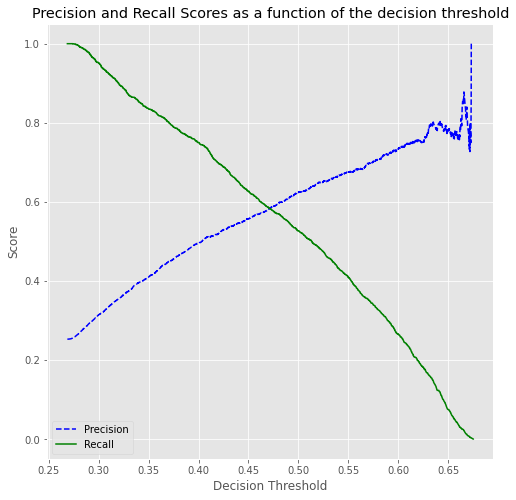

In [222]:
p, r, thresholds = precision_recall_curve(y_test, preds)
plot_precision_recall_vs_threshold(p, r, thresholds)


In [30]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'nar_recall_score': make_scorer(recall_score,average='binary'),
#     'accuracy_score': make_scorer(accuracy_score),
    'f1_weighted_score': make_scorer(f1_score,
                        average='weighted'),
    'f1_macro_score': make_scorer(f1_score,
                        average='macro'),
    'f1_micro_score': make_scorer(f1_score,
                    average='micro')
}
def grid_search_wrapper(clf,param_grid,refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = train_splitter#StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1,verbose=4)
    grid_search.fit(X=X,y=y,groups=groups)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

columns=[]
for k in scorers.keys():
    columns.append('mean_test_{}'.format(k))

In [237]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')
results = pd.DataFrame(grid_search_clf.cv_results_)

results = results.sort_values(by='mean_test_f1_weighted_score', ascending=False)
results[columns].head()


Fitting 7 folds for each of 24 candidates, totalling 168 fits
Best params for precision_score
{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg      4314       441
pos       813       797


,mean_test_precision_score,mean_test_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
9,0.695485,0.429533,0.795886,0.701281,0.811373
11,0.692739,0.429164,0.795655,0.700784,0.811099
8,0.693450,0.427530,0.795562,0.700107,0.811173
6,0.694037,0.428616,0.795546,0.700713,0.811082
10,0.695296,0.424929,0.795311,0.699277,0.811239


In [246]:
grid_search_clf = grid_search_wrapper(refit_score='nar_recall_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_nar_recall_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 24 candidates, totalling 168 fits
Best params for nar_recall_score
{'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for nar_recall_score on the test data:
     pred_neg  pred_pos
neg      4547       208
pos       427      1183


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
22,0.636615,0.436682,0.786663,0.691498,0.799504
23,0.635581,0.436669,0.786460,0.691260,0.799234
18,0.571714,0.435550,0.771019,0.673419,0.780965
19,0.571845,0.434431,0.771393,0.673494,0.781492
20,0.595090,0.433921,0.777049,0.679862,0.788356


In [263]:
clf=SGDClassifier(n_jobs=-1)
param_grid = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

grid_search_clf = grid_search_wrapper(clf,param_grid,refit_score='nar_recall_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_nar_recall_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 48 candidates, totalling 336 fits
Best params for nar_recall_score
{'alpha': 0.01, 'loss': 'squared_hinge', 'penalty': 'l1'}

Confusion matrix of Random Forest optimized for nar_recall_score on the test data:
     pred_neg  pred_pos
neg      3793       962
pos       683       927


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
31,0.538836,0.516100,0.771046,0.685488,0.772246
32,0.544903,0.514924,0.773228,0.687780,0.775153
7,0.666822,0.449025,0.793500,0.700726,0.806791
44,0.668992,0.441820,0.793713,0.699380,0.807282
13,0.661449,0.438731,0.792139,0.695876,0.805907


# Find best parameters for RandomForestClassifier

In [91]:
imp.reload(classes)
pipe = make_pipeline(classes.PredictionTransformer(RandomForestClassifier()),
                     classes.ThresholdClassifier())

pipe_param_grid = {
    'predictiontransformer__clf__max_depth': [1, 2, 5, 10, 20, 30, 40, 50],
    'predictiontransformer__clf__max_features': [8, 16, 32, 64, 80, 100],
#     'thresholdclassifier__threshold': np.linspace(0.80, 0.999, num=30)
    }

In [92]:
grid_search_clf = grid_search_wrapper(pipe,pipe_param_grid,refit_score='nar_recall_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 48 candidates, totalling 336 fits
[0 1]
X shape (6365, 2)
Best params for nar_recall_score
{'predictiontransformer__clf__max_depth': 1, 'predictiontransformer__clf__max_features': 32}

Confusion matrix of Random Forest optimized for nar_recall_score on the test data:
     pred_neg  pred_pos
neg      3922       833
pos       615       995


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
17,0.694880,0.433333,0.796600,0.702363,0.811658
13,0.693504,0.433000,0.796154,0.701970,0.811219
16,0.693833,0.430538,0.795734,0.701048,0.811071
14,0.692369,0.432681,0.795936,0.701685,0.810980
12,0.689783,0.431089,0.795411,0.700560,0.810600


# Find best theshold on best params

In [97]:
best_params=grid_search_clf.best_params_
best_params

{'predictiontransformer__clf__max_depth': 1,
 'predictiontransformer__clf__max_features': 32,
 'thresholdclassifier__threshold': array([0.8       , 0.80686207, 0.81372414, 0.82058621, 0.82744828,
        0.83431034, 0.84117241, 0.84803448, 0.85489655, 0.86175862,
        0.86862069, 0.87548276, 0.88234483, 0.8892069 , 0.89606897,
        0.90293103, 0.9097931 , 0.91665517, 0.92351724, 0.93037931,
        0.93724138, 0.94410345, 0.95096552, 0.95782759, 0.96468966,
        0.97155172, 0.97841379, 0.98527586, 0.99213793, 0.999     ])}

In [99]:
fixed_pipe=make_pipeline(classes.PredictionTransformer(
                    RandomForestClassifier(
                        max_depth=1,
                        max_features=32
                        )
                     ),
                     classes.ThresholdClassifier())
threshold_params = {
#     'predictiontransformer__clf__max_depth': [1, 2, 5, 10, 20, 30, 40, 50],
#     'predictiontransformer__clf__max_features': [8, 16, 32, 64, 80, 100],
    'thresholdclassifier__threshold': np.linspace(0.80, 0.999, num=30)
    }
grid_search_clf = grid_search_wrapper(fixed_pipe,threshold_params,refit_score='nar_recall_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 30 candidates, totalling 210 fits
[0 1]
X shape (6365, 2)
Best params for nar_recall_score
{'thresholdclassifier__threshold': 0.8617586206896553}

Confusion matrix of Random Forest optimized for nar_recall_score on the test data:
     pred_neg  pred_pos
neg         0      4755
pos         0      1610


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
1,0.566879,0.561368,0.781143,0.700061,0.781469
0,0.565763,0.557789,0.780606,0.698268,0.781255
2,0.558064,0.571048,0.780276,0.700096,0.779622
3,0.558243,0.568812,0.779616,0.699089,0.779158
4,0.556183,0.573535,0.779543,0.699428,0.778793


In [105]:
grid_search_clf = grid_search_wrapper(fixed_pipe,threshold_params,refit_score='f1_macro_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_macro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 30 candidates, totalling 210 fits
[0 1]
X shape (6365, 2)
Best params for f1_macro_score
{'thresholdclassifier__threshold': 0.8}

Confusion matrix of Random Forest optimized for f1_macro_score on the test data:
     pred_neg  pred_pos
neg      3300      1455
pos       353      1257


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
0,0.505133,0.725516,0.767933,0.705212,0.756782
1,0.509540,0.721943,0.766919,0.704304,0.755764
3,0.498948,0.734870,0.760589,0.699169,0.748405
6,0.474102,0.757646,0.747960,0.686790,0.734802
2,0.471787,0.767740,0.742342,0.683751,0.726464


# Find threshold on SVC

In [137]:
imp.reload(classes)
fixed_pipe=make_pipeline(classes.PredictionTransformer(
                    SGDClassifier(
                        loss='log',
                        penalty='l1',
                        alpha=0.0001
                        )
                     ),
                     classes.ThresholdClassifier())
threshold_params = {
#     'predictiontransformer__clf__max_depth': [1, 2, 5, 10, 20, 30, 40, 50],
#     'predictiontransformer__clf__max_features': [8, 16, 32, 64, 80, 100],
    'thresholdclassifier__threshold': np.linspace(0.15, 0.25, num=30)
    }
grid_search_clf = grid_search_wrapper(fixed_pipe,threshold_params,refit_score='f1_macro_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_macro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 30 candidates, totalling 210 fits
[0 1]
X shape (6365, 2)
Best params for f1_macro_score
{'thresholdclassifier__threshold': 0.15}

Confusion matrix of Random Forest optimized for f1_macro_score on the test data:
     pred_neg  pred_pos
neg        20      4735
pos        62      1548


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
0,0.241601,0.949899,0.106854,0.193620,0.241324
5,0.241313,0.950906,0.105664,0.193021,0.240163
1,0.239460,0.938311,0.106292,0.192087,0.238478
10,0.233289,0.902976,0.110935,0.191566,0.234316
6,0.233377,0.904771,0.108232,0.189957,0.232615


In [131]:
common_utils.dump_to_file(grid_search_clf,dir_name,"grid_search_clf.SGD.th.20")

In [132]:
grid_search_clf.best_estimator_

Pipeline(steps=[('predictiontransformer',
                 PredictionTransformer(clf=SGDClassifier(loss='log',
                                                         penalty='l1'))),
                ('thresholdclassifier', ThresholdClassifier(threshold=0.8))])

In [133]:
grid_search_clf.best_params_

{'thresholdclassifier__threshold': 0.8}

init >> MyGrid


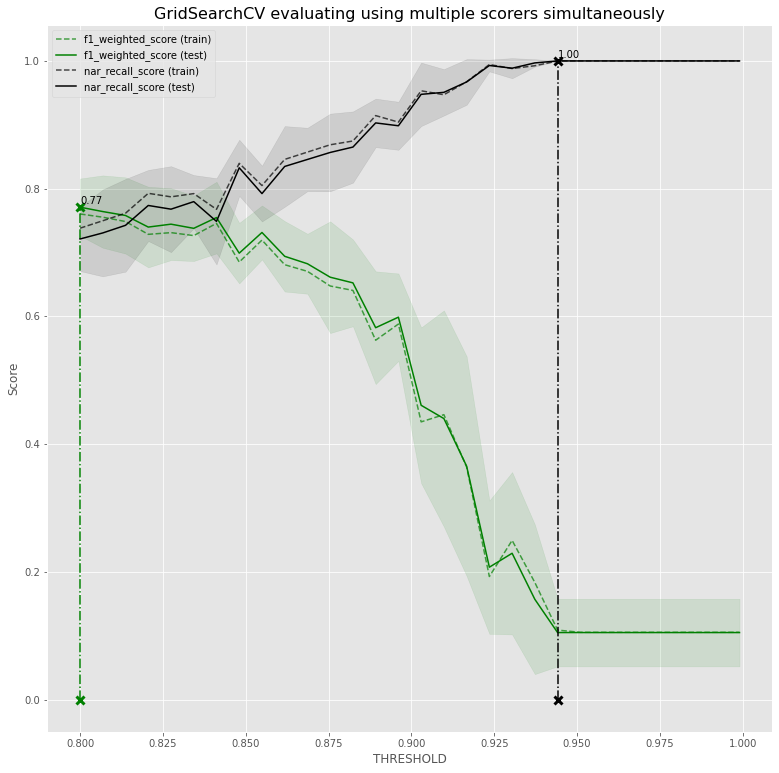

In [134]:
imp.reload(classes)
myGrid=classes.MyGrid()
myGrid.plot(grid_search_clf.cv_results_,'thresholdclassifier__threshold',['nar_recall_score','f1_weighted_score'])

In [107]:
results_recall = results_recall.sort_values(by='mean_test_f1_weighted_score', ascending=False)
results_recall[columns].head()

,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
2,0.492239,0.734666,0.760763,0.697960,0.748096
0,0.493600,0.737595,0.755760,0.694103,0.743940
1,0.486372,0.749413,0.753469,0.692993,0.741410
5,0.478470,0.755972,0.749355,0.688706,0.735656
4,0.473567,0.762799,0.745578,0.685620,0.732934


# Make custom pipe for threshold selection

In [48]:
imp.reload(classes)
grid_search_clf = grid_search_wrapper(pipe,pipe_param_grid,refit_score='nar_recall_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 30 candidates, totalling 210 fits
[0 1]
X shape (6365, 2)
Best params for nar_recall_score
{'thresholdclassifier__threshold': 0.999}

Confusion matrix of Random Forest optimized for nar_recall_score on the test data:
     pred_neg  pred_pos
neg      1530      3225
pos         0      1610


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
1,0.423977,0.715893,0.712976,0.646851,0.694103
0,0.421607,0.713489,0.711531,0.644878,0.692546
2,0.417942,0.721195,0.707722,0.642102,0.688251
3,0.413345,0.732097,0.702839,0.638502,0.682628
4,0.413372,0.732475,0.702438,0.638223,0.682127


In [49]:
print(grid_search_clf.best_params_)


{'thresholdclassifier__threshold': 0.999}


In [50]:
grid_search_clf = grid_search_wrapper(pipe,pipe_param_grid,refit_score='f1_micro_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 30 candidates, totalling 210 fits
[0 1]
X shape (6365, 2)
Best params for f1_micro_score
{'thresholdclassifier__threshold': 0.8}

Confusion matrix of Random Forest optimized for f1_micro_score on the test data:
     pred_neg  pred_pos
neg      4089       666
pos         0      1610


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
0,0.424621,0.713922,0.714044,0.647476,0.695315
1,0.421027,0.710328,0.711108,0.644213,0.692192
2,0.416588,0.719696,0.706655,0.640742,0.687009
4,0.413039,0.731180,0.702274,0.637902,0.682082
3,0.412180,0.732320,0.701206,0.637095,0.681039


In [60]:
pipe_param_grid = {
#     "predictiontransformer__clf__loss" : ["log", "modified_huber"],
#     "predictiontransformer__clf__alpha" : [0.0001, 0.001, 0.01, 0.1],
#     "predictiontransformer__clf__penalty" : ["l2", "l1", "none"],
     'thresholdclassifier__threshold': np.linspace(0.80, 0.90, num=15)
}

pipe = make_pipeline(classes.PredictionTransformer(
                    SGDClassifier(n_jobs=-1,
                                 loss='log',
                                 penalty='l2',
                                 alpha=0.0001)
                        ),
                     classes.ThresholdClassifier())

grid_search_clf = grid_search_wrapper(pipe,pipe_param_grid,refit_score='f1_micro_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 15 candidates, totalling 105 fits
[0 1]
X shape (6365, 2)
Best params for f1_micro_score
{'thresholdclassifier__threshold': 0.8}

Confusion matrix of Random Forest optimized for f1_micro_score on the test data:
     pred_neg  pred_pos
neg      3454      1301
pos       384      1226


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
0,0.498040,0.732079,0.765353,0.702801,0.753055
3,0.484894,0.749495,0.755453,0.694237,0.741841
4,0.478568,0.755901,0.753894,0.692564,0.740254
1,0.479639,0.753122,0.749084,0.688368,0.736143
2,0.474331,0.763180,0.746917,0.687110,0.733538


# Going wild with pipe

In [63]:
reg={}
for regr in feature_utils.regressors_type:
    reg[regr.__class__.__name__]=regr
reg

{'LogisticRegression': LogisticRegression(n_jobs=-1, random_state=0),
 'LogisticRegressionCV': LogisticRegressionCV(n_jobs=-1, random_state=0),
 'PassiveAggressiveClassifier': PassiveAggressiveClassifier(n_jobs=-1, random_state=0),
 'Perceptron': Perceptron(n_jobs=-1),
 'RidgeClassifier': RidgeClassifier(random_state=0),
 'SGDClassifier': SGDClassifier(n_jobs=-1, random_state=0),
 'SVC': SVC(probability=True, random_state=0),
 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=0)}

In [87]:
from sklearn.tree import DecisionTreeRegressor
pipe = Pipeline([('regressor', RidgeClassifier())])

# check out searchgrid for more convenience
param_grid = [
# {'regressor': [SGDClassifier()],
#                "regressor__loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
#                 "regressor__alpha" : [0.0001, 0.001, 0.01, 0.1],
#                 "regressor__penalty" : ["l2", "l1", "none"]} ,
#               {'regressor': [RidgeClassifier()],
#                'regressor__alpha': [1,0.1,0.01,0.001,0.0001,0], 
#                "regressor__fit_intercept": [True, False]},
#               {'regressor': [LogisticRegression(n_jobs=-1)],
#               'regressor__C' :np.logspace(-3,3,7), 
#                "regressor__penalty":["l1","l2"]},
#               {'regressor': [DecisionTreeClassifier()],
#               'regressor__max_depth': np.arange(3,10,1),
#                'regressor__min_samples_leaf': np.arange(3,10,1)},
              {'regressor': [SVC(probability=True)],
                'regressor__C': [0.1,1, 10, 100],
                'regressor__gamma': [1,0.1,0.01,0.001],
               'regressor__kernel': ['rbf', 'poly', 'sigmoid']}
             ]


In [80]:
grid_search_clf = grid_search_wrapper(pipe,param_grid,refit_score='f1_micro_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 60 candidates, totalling 420 fits
Best params for f1_micro_score
{'regressor': SGDClassifier(loss='log', penalty='l1'), 'regressor__alpha': 0.0001, 'regressor__loss': 'log', 'regressor__penalty': 'l1'}

Confusion matrix of Random Forest optimized for f1_micro_score on the test data:
     pred_neg  pred_pos
neg      4223       532
pos       747       863


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
4,0.688798,0.424579,0.795899,0.700040,0.811899
15,0.693117,0.411628,0.792376,0.693275,0.809621
29,0.684991,0.427453,0.794164,0.698047,0.809613
1,0.666212,0.435361,0.795239,0.700515,0.809417
17,0.684173,0.432122,0.794380,0.699006,0.809305


In [83]:
# grid_search_clf = grid_search_wrapper(pipe,param_grid,refit_score='nar_recall_score')
# results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_nar_recall_score', ascending=False)
results_recall[columns].head()

,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
10,0.650161,0.466109,0.793062,0.699214,0.805030
8,0.672033,0.461921,0.791427,0.697973,0.804579
0,0.658695,0.454644,0.794735,0.700874,0.807203
2,0.662381,0.450590,0.790920,0.698890,0.803524
9,0.669314,0.448425,0.791475,0.698692,0.804625


In [85]:
grid_search_clf = grid_search_wrapper(pipe,param_grid,refit_score='nar_recall_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 63 candidates, totalling 441 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
49 fits failed out of a total of 441.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
49 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn

Best params for nar_recall_score
{'regressor': DecisionTreeClassifier(max_depth=6, min_samples_leaf=3), 'regressor__max_depth': 6, 'regressor__min_samples_leaf': 3}

Confusion matrix of Random Forest optimized for nar_recall_score on the test data:
     pred_neg  pred_pos
neg      4352       403
pos       814       796


,mean_test_precision_score,mean_test_nar_recall_score,mean_test_f1_weighted_score,mean_test_f1_macro_score,mean_test_f1_micro_score
7,0.685779,0.428157,0.794345,0.698316,0.809755
9,0.685779,0.428157,0.794345,0.698316,0.809755
11,0.685779,0.428157,0.794345,0.698316,0.809755
13,0.685779,0.428157,0.794345,0.698316,0.809755
3,0.699293,0.403951,0.791367,0.690904,0.809570


In [88]:
grid_search_clf = grid_search_wrapper(pipe,param_grid,refit_score='nar_recall_score')
results_recall = pd.DataFrame(grid_search_clf.cv_results_)
results_recall = results_recall.sort_values(by='mean_test_f1_micro_score', ascending=False)
results_recall[columns].head()

Fitting 7 folds for each of 48 candidates, totalling 336 fits


KeyboardInterrupt: 